In [85]:
######## Importing the necessary libraries #########


import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.constants import c, k_B,R_earth


%matplotlib inline   

In [86]:
R_E=R_earth.to('km').value

In [87]:
##### Fetching the cleaned FM transmitter data for the countries: CANADA, AUSTRALIA ,GERMANY,USA and SOUTH AFRICA ####
#####  EIRP in Watts #####
##### Latitude ranges from 90(N.Pole) to 0 (EQUATOR) to -90(S.Pole) ########
##### Longitude ranges between 0 and 360 degree eastwards ############


#Reading the CSV file
df=pd.read_csv("/home/ghoshsonia/rfi_RRI/Final_Revised.csv")

#Removing the Null/missing values in the CSV file
df.dropna(subset = ["Latitude in degrees"], inplace=True)


#df.set_index("Area Served", inplace = True) # Set 'Area Served' column as index on a Dataframe
#df=df.loc[["Perth", "Perth City"]] # Using the operator .loc[] to select multiple rows from the Dataframe
df

,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP
0,50.947181,8.532986,87.6,164000.0
1,53.509289,10.093932,87.6,131200.0
2,49.832397,9.592726,87.6,41000.0
3,49.629033,7.820645,87.6,820.0
4,49.681928,7.327415,87.6,328.0
...,...,...,...,...
15610,39.418667,278.557944,88.3,9200.0
15611,38.761750,276.938722,88.3,1700.0
15612,38.722639,276.938722,88.3,1700.0
15613,41.117833,276.456194,88.3,4600.0


In [88]:
###### User defined frequency axis ######################


def get_non_negative_int(prompt):
    while True:
        try:
            value = float(input(prompt))
        except ValueError:
            print("There is an error in the input.")
            continue

        if value<=0:
            print("There is an error in the input.The input cannot be zero or negative")
       # elif value<0:
        #    print("The input must not be negative.")
            continue
        else:
            break
    return value

fstart = get_non_negative_int("Please enter the minimum value of the frequency range: ")
fstop = get_non_negative_int("Please enter the maximum value of the frequency range: ")
fres=get_non_negative_int("Please enter the resolution of the frequency: ")


Please enter the minimum value of the frequency range: 87
Please enter the maximum value of the frequency range: 108
Please enter the resolution of the frequency: 0.5


In [89]:
freq=np.arange(fstart,fstop,fres)

#### Array consisting of frequencies from the dataset
data_freq=df['Frequency(MHz)'].values



diff=np.zeros((len(data_freq),len(freq)),dtype=object)
freq_arr=np.zeros(len(data_freq))


for i in range(len(data_freq)):
    for j in range(len(freq)):
        diff[i][j]=abs(data_freq[i]-freq[j])
        freq_arr[i]=freq[np.argmin(diff[i])]

# freq

In [65]:
freq

array([ 87. ,  87.5,  88. ,  88.5,  89. ,  89.5,  90. ,  90.5,  91. ,
        91.5,  92. ,  92.5,  93. ,  93.5,  94. ,  94.5,  95. ,  95.5,
        96. ,  96.5,  97. ,  97.5,  98. ,  98.5,  99. ,  99.5, 100. ,
       100.5, 101. , 101.5, 102. , 102.5, 103. , 103.5, 104. , 104.5,
       105. , 105.5, 106. , 106.5, 107. , 107.5])

In [90]:
df['New Frequency']=freq_arr
df

,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP,New Frequency
0,50.947181,8.532986,87.6,164000.0,87.5
1,53.509289,10.093932,87.6,131200.0,87.5
2,49.832397,9.592726,87.6,41000.0,87.5
3,49.629033,7.820645,87.6,820.0,87.5
4,49.681928,7.327415,87.6,328.0,87.5
...,...,...,...,...,...
15610,39.418667,278.557944,88.3,9200.0,88.5
15611,38.761750,276.938722,88.3,1700.0,88.5
15612,38.722639,276.938722,88.3,1700.0,88.5
15613,41.117833,276.456194,88.3,4600.0,88.5


In [95]:
#Resolution of the map
print('-----------Resolution of the map---------') 
nside = 4
print(f"The number of pixels for the given NSIDE: {(hp.nside2npix(nside))}")
print(f"Approximate resolution in degrees for given nside {np.degrees(hp.nside2resol(nside)):.2f}")
print( "Pixel area: %.2f square degrees" % hp.nside2pixarea(nside, degrees=True))



-----------Resolution of the map---------
The number of pixels for the given NSIDE: 192
Approximate resolution in degrees for given nside 14.66
Pixel area: 214.86 square degrees


In [96]:

######-------------------Allocating Pixel number to the Latitude and Longitude of each Tx in the CSV---------#######



# Healpy pixel number when input angles are assumed to be longitude and latitude in degrees
pixel_indices = hp.ang2pix(nside, df['Longitude in degrees'].to_numpy() ,df['Latitude in degrees'].to_numpy(),lonlat=True)
df['Pixel_number']=pixel_indices 
print(pixel_indices)

df

[12 12 24 ... 36 36 36]


/home/ghoshsonia/.local/lib/python3.8/site-packages/healpy/pixelfunc.py:482: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP,New Frequency,Pixel_number
0,50.947181,8.532986,87.6,164000.0,87.5,12
1,53.509289,10.093932,87.6,131200.0,87.5,12
2,49.832397,9.592726,87.6,41000.0,87.5,24
3,49.629033,7.820645,87.6,820.0,87.5,24
4,49.681928,7.327415,87.6,328.0,87.5,24
...,...,...,...,...,...,...
15610,39.418667,278.557944,88.3,9200.0,88.5,36
15611,38.761750,276.938722,88.3,1700.0,88.5,36
15612,38.722639,276.938722,88.3,1700.0,88.5,36
15613,41.117833,276.456194,88.3,4600.0,88.5,36


In [97]:
#######---------------Conversion of the pixel numbers w.r.t the given NSIDE to corresponding angular coordinates--------#######


NPIX = hp.nside2npix(nside) # Storing the number of pixels of the map corresponding to the given NSIDE
arr=np.arange(NPIX) #Create an an array of pixel numbers with respect to the NSIDE

phi,theta = (hp.pix2ang(nside, ipix=arr,lonlat=True)) # Array of the angular coordinates co-latitude(theta) 
                                                        #and longitude(phi) in degrees 
                                                       # With respect to the given NSIDE


In [98]:
NPIX

192

In [28]:
arr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [99]:
phi

array([ 45.  , 135.  , 225.  , 315.  ,  22.5 ,  67.5 , 112.5 , 157.5 ,
       202.5 , 247.5 , 292.5 , 337.5 ,  15.  ,  45.  ,  75.  , 105.  ,
       135.  , 165.  , 195.  , 225.  , 255.  , 285.  , 315.  , 345.  ,
        11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75,
       191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75,
         0.  ,  22.5 ,  45.  ,  67.5 ,  90.  , 112.5 , 135.  , 157.5 ,
       180.  , 202.5 , 225.  , 247.5 , 270.  , 292.5 , 315.  , 337.5 ,
        11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75,
       191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75,
         0.  ,  22.5 ,  45.  ,  67.5 ,  90.  , 112.5 , 135.  , 157.5 ,
       180.  , 202.5 , 225.  , 247.5 , 270.  , 292.5 , 315.  , 337.5 ,
        11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75,
       191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75,
         0.  ,  22.5 ,  45.  ,  67.5 ,  90.  , 112.5 , 135.  , 157.5 ,
      

In [350]:
theta

array([ 78.28414761,  78.28414761,  78.28414761,  78.28414761,
        66.44353569,  66.44353569,  66.44353569,  66.44353569,
        66.44353569,  66.44353569,  66.44353569,  66.44353569,
        54.3409123 ,  54.3409123 ,  54.3409123 ,  54.3409123 ,
        54.3409123 ,  54.3409123 ,  54.3409123 ,  54.3409123 ,
        54.3409123 ,  54.3409123 ,  54.3409123 ,  54.3409123 ,
        41.8103149 ,  41.8103149 ,  41.8103149 ,  41.8103149 ,
        41.8103149 ,  41.8103149 ,  41.8103149 ,  41.8103149 ,
        41.8103149 ,  41.8103149 ,  41.8103149 ,  41.8103149 ,
        41.8103149 ,  41.8103149 ,  41.8103149 ,  41.8103149 ,
        30.        ,  30.        ,  30.        ,  30.        ,
        30.        ,  30.        ,  30.        ,  30.        ,
        30.        ,  30.        ,  30.        ,  30.        ,
        30.        ,  30.        ,  30.        ,  30.        ,
        19.47122063,  19.47122063,  19.47122063,  19.47122063,
        19.47122063,  19.47122063,  19.47122063,  19.47

In [100]:
#######------------------Altitudes of the satellite orbit--------####


#Creating user defined data points between 400 km to 36000 km in log scale
data_point=int(input("Enter number of data points : "))
altitude= np.logspace(np.log10(400),np.log10(3800),data_point) 
print(altitude)

Enter number of data points : 1
[400.]


In [135]:
#Calculation of Elevation angle

x=[] 
y=[]
elev_ang=np.zeros((len(altitude),NPIX,NPIX),dtype=object)

for k in range(len(altitude)):
    for i in range(len(theta)):
        for j in range(len(theta)):
        
            x.append((np.cos(np.radians(theta[i])))*(np.cos(np.radians(theta[j])))*(np.cos(np.radians(phi[j]-phi[i])))+(np.sin(np.radians(theta[i])))*(np.sin(np.radians(theta[j]))))
            y=(np.arccos(x))
            B=(altitude[k]+R_E)/R_E
            elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y)))/np.sin(np.radians(y))))-y)

<ipython-input-135-fb1009ee5968>:14: RuntimeWarning: divide by zero encountered in true_divide
  elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y)))/np.sin(np.radians(y))))-y)


In [101]:
x=np.zeros((NPIX,NPIX))
y=np.zeros((NPIX,NPIX))
elev_ang=np.zeros((len(altitude),NPIX,NPIX))
#R_E=6400
for k in range(len(altitude)):
    for i in range(len(theta)):
        for j in range(len(theta)):
        
            x[i,j]=((np.cos(np.radians(theta[i])))*(np.cos(np.radians(theta[j])))*(np.cos(np.radians(phi[j]-phi[i])))+(np.sin(np.radians(theta[i])))*(np.sin(np.radians(theta[j]))))
            y[i,j]=(np.arccos(x[i,j]))
            B=(altitude[k]+R_E)/R_E
            elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y[i,j])))/np.sin(np.radians(y[i,j]))))-y[i,j])

<ipython-input-101-12ba9066e5ac>:12: RuntimeWarning: divide by zero encountered in double_scalars
  elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y[i,j])))/np.sin(np.radians(y[i,j]))))-y[i,j])


In [102]:
np.shape(elev_ang)

(1, 192, 192)

In [103]:
elev_ang

array([[[-90.        , -85.12774664, -83.10067141, ..., -49.24993783,
         -46.3807117 , -49.24993783],
        [-85.12774664, -90.        , -85.12774664, ..., -50.52024135,
         -49.24993783, -46.3807117 ],
        [-83.10067141, -85.12774664, -90.        , ..., -49.24993783,
         -50.52024135, -49.24993783],
        ...,
        [-49.24993783, -50.52024135, -49.24993783, ..., -90.        ,
         -85.12774664, -83.10067141],
        [-46.3807117 , -49.24993783, -50.52024135, ..., -85.12774664,
         -90.        , -85.12774664],
        [-49.24993783, -46.3807117 , -49.24993783, ..., -83.10067141,
         -85.12774664, -90.        ]]])

In [127]:
central_ang=np.arccos((np.cos(np.radians(theta[0])))*(np.cos(np.radians(theta[0])))*(np.cos(np.radians(phi[0]-phi[0])))+(np.sin(np.radians(theta[0])))*(np.sin(np.radians(theta[0]))))

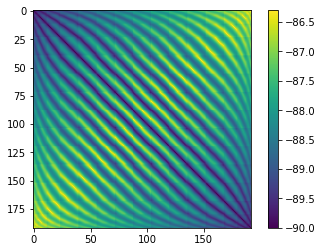

In [428]:
plt.imshow(np.resize(elev_ang,(NPIX,NPIX))) # 400km # with phi=100
plt.colorbar()

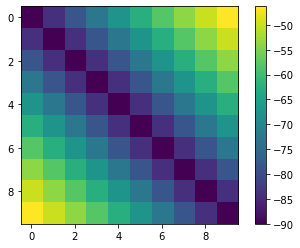

In [23]:
plt.imshow(np.resize(ang,(10,10))) # 400km # with phi=100
plt.colorbar()

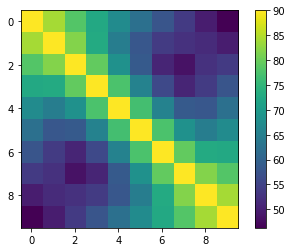

In [135]:
plt.imshow(np.resize(ang,(10,10)))# 400km # with VARYING phi
plt.colorbar()

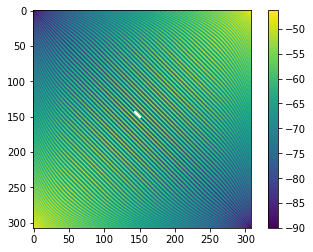

In [42]:
plt.imshow(np.resize(ang,(308,308)))# 400km # with VARYING phi
plt.colorbar()

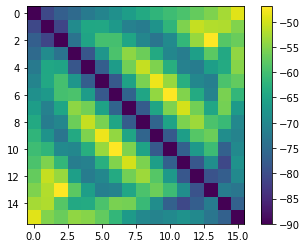

In [64]:
plt.imshow(np.resize(ang,(16,16)))# 400km # with VARYING phi
plt.colorbar()


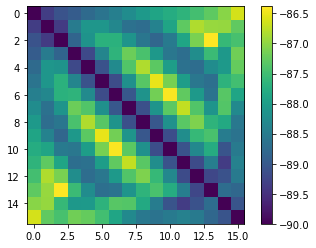

In [66]:
plt.imshow(np.resize(ang,(16,16)))# 36000km # with VARYING phi
plt.colorbar()

In [106]:
df_el.iloc[0]
pixel_ind2 = np.where(df_el.iloc[0]<0)
print(pixel_ind2)

(array([   0,    1,    2, ..., 1580, 1581, 1582]),)


In [104]:
# Function for Radiation pattern of the satellite antenna beam #
beam_pattern=np.zeros((len(altitude),NPIX,NPIX))
beam = lambda theta, phi:(np.cos(np.radians(theta)))**2                              # (np.sin(np.radians(theta)))**2

In [105]:
# Assuming the satellite antenna beam to be symmetric across azimuth #
# Calculation of the beam pattern #

az=0
beam_pattern = beam(elev_ang,az)
#beam_pattern =np.resize(beam_pattern,(np.size(theta),np.size(theta)))

In [34]:
np.shape(beam_pattern )

(2, 48, 48)

In [47]:
df22221 = pd.DataFrame(beam_pattern) # 400km # with healpy phi
df22221

ValueError: Must pass 2-d input. shape=(2, 48, 48)

In [427]:
df22221 = pd.DataFrame(beam_pattern) # 400km # with healpy phi
df22221

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,3.749399e-33,3.508762e-05,7.066949e-05,3.508762e-05,2.330930e-05,0.000023,0.000061,0.000115,0.000155,0.000155,...,0.002895,0.003218,0.003565,0.003565,0.003218,2.895013e-03,3.151431e-03,3.435825e-03,4.163635e-03,3.435825e-03
1,3.508762e-05,3.749399e-33,3.508762e-05,7.066949e-05,1.154081e-04,0.000061,0.000023,0.000023,0.000061,0.000115,...,0.002716,0.002716,0.002895,0.003218,0.003565,3.565187e-03,3.435825e-03,3.151431e-03,3.435825e-03,4.163635e-03
2,7.066949e-05,3.508762e-05,3.749399e-33,3.508762e-05,1.545730e-04,0.000155,0.000115,0.000061,0.000023,0.000023,...,0.003218,0.002895,0.002716,0.002716,0.002895,3.218251e-03,4.163635e-03,3.435825e-03,3.151431e-03,3.435825e-03
3,3.508762e-05,7.066949e-05,3.508762e-05,3.749399e-33,6.104933e-05,0.000115,0.000155,0.000155,0.000115,0.000061,...,0.003565,0.003565,0.003218,0.002895,0.002716,2.716291e-03,3.435825e-03,4.163635e-03,3.435825e-03,3.151431e-03
4,2.330930e-05,1.154081e-04,1.545730e-04,6.104933e-05,9.382577e-20,0.000040,0.000139,0.000242,0.000286,0.000242,...,0.002785,0.003390,0.004164,0.003390,0.002785,2.401782e-03,2.716291e-03,3.218251e-03,3.565187e-03,2.895013e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.895013e-03,3.565187e-03,3.218251e-03,2.716291e-03,2.401782e-03,0.002785,0.003390,0.004164,0.003390,0.002785,...,0.000242,0.000286,0.000242,0.000139,0.000040,3.749399e-33,6.104933e-05,1.545730e-04,1.154081e-04,2.330930e-05
188,3.151431e-03,3.435825e-03,4.163635e-03,3.435825e-03,2.716291e-03,0.002716,0.002895,0.003218,0.003565,0.003565,...,0.000061,0.000115,0.000155,0.000155,0.000115,6.104933e-05,3.749399e-33,3.508762e-05,7.066949e-05,3.508762e-05
189,3.435825e-03,3.151431e-03,3.435825e-03,4.163635e-03,3.218251e-03,0.002895,0.002716,0.002716,0.002895,0.003218,...,0.000023,0.000023,0.000061,0.000115,0.000155,1.545730e-04,3.508762e-05,3.749399e-33,3.508762e-05,7.066949e-05
190,4.163635e-03,3.435825e-03,3.151431e-03,3.435825e-03,3.565187e-03,0.003565,0.003218,0.002895,0.002716,0.002716,...,0.000115,0.000061,0.000023,0.000023,0.000061,1.154081e-04,7.066949e-05,3.508762e-05,3.749399e-33,3.508762e-05


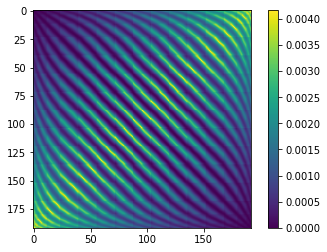

In [426]:
# Verify
plt.imshow(beam_pattern)
plt.colorbar()

In [106]:
###########----------------- Calculation of Field of view of the satellite---------#######
###########-----------------Considering Nadir-pointing Field of View Geometry-------######
##########-----------------Considering the FOV of the satellite to be tangent to the surface of the Earth------######


FOV=np.zeros(len(altitude))
for i in range(0,len(altitude)):
# Consider a case of full coverage under elevation of 0 º
    #Rad= 6371 # Mean radius of Earth in km
    FOV[i]= 2*np.arcsin(R_E/(R_E+ altitude[i]))  # Field of view for maximal coverage in radians when elevation is 0 º 
    print(" The Field of view of the satellite at a height of",altitude[i],"km is",FOV[i], "radians")

 The Field of view of the satellite at a height of 400.0000000000001 km is 2.4510662859463395 radians


In [107]:
###########----------------- Calculation of the radius of the FOV of the satellite---------#######



# The surface of the coverage area of the Earth depends on the central angle
Central_angle=np.zeros(len(altitude))
for i in range(0,len(altitude)):
    Central_angle[i]=np.arccos(R_E/(R_E+altitude[i])) # Central angle in radians
    
    Dia_of_FOV=2*Central_angle*R_E  # Diameter of the FOV (disc on the Earth's surface)in km
    Rad_of_FOV= Dia_of_FOV/2 # Radius of the FOV in km
    Rad_of_FOV=Rad_of_FOV/R_E  # Radius of the FOV in Radians
    print(" The Radius of the Field of View for a height of",altitude[i],"km in radians is",Rad_of_FOV[i])
len(Rad_of_FOV)

 The Radius of the Field of View for a height of 400.0000000000001 km in radians is 0.34526318382172694


1

In [144]:
90-np.degrees(Central_angle[0]) # Max observable latitude at 400km

70.20740346885583

In [149]:
90-np.degrees(FOV[0]) # Elevation angle w.r.t geometric FOV

-50.41480693771166

In [108]:
###############-----Storing indices of the pixel number that are inside the circle/disc(FOV) wrt the altitude-----------######


vec1 = hp.ang2vec(phi,theta,lonlat=True) #Using ang2vec convert angles that is co-latitude and longitude in radians
                                        #to 3D position vector
    
disc=np.zeros((len(arr),len(Rad_of_FOV)),dtype=object)#Array of indices of the pixel number that are inside the 
                                                      #circle/disc specified by vec and radius
def pixel_disc(a,b):
    for i in range(len(a)):
        for j in range(len(b)):
            disc[j][i]=hp.query_disc(nside, vec1[j], radius=a[i])
pixel_disc(Rad_of_FOV,arr)

In [109]:
#########------- Cross checking the array being created-----#########

df1 = pd.DataFrame(disc)
df1

,0
0,"[0, 1, 3, 4, 5]"
1,"[0, 1, 2, 6, 7]"
2,"[1, 2, 3, 8, 9]"
3,"[0, 2, 3, 10, 11]"
4,"[0, 4, 5, 11, 12, 13]"
...,...
187,"[178, 179, 180, 186, 187, 191]"
188,"[180, 181, 188, 189, 191]"
189,"[182, 183, 188, 189, 190]"
190,"[184, 185, 189, 190, 191]"


In [110]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no------####


Comm_pix=np.zeros((len(disc[:,i]),len(Rad_of_FOV)),dtype=object)

for i in range(len(Rad_of_FOV)):
    for k in range(len(disc[:,i])):
     

         Comm_pix[k][i]=np.intersect1d(pixel_indices,disc[k][i])#Array of indices of the pixel number that are
                                                           #common between the FOV disc and the satellite pixel no
         

In [111]:
#########------- Cross checking the array being created-----#########


df2 = pd.DataFrame(Comm_pix)
df2

,0
0,[]
1,[2]
2,"[2, 8, 9]"
3,"[2, 10]"
4,[12]
...,...
187,[]
188,[]
189,[]
190,[]


In [112]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no ------#
######-----And the same pixel number of the transmitters-----##



######--- Initializing the array to store the pixel number that are common between the FOV disc ---####
######                        and the satellite pixel no    ######
Comm_TX=np.zeros((len(Comm_pix),len(Rad_of_FOV)),dtype=object)
found_common=np.zeros(( len(Comm_pix),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(Comm_pix)):
        
        Comm_TX[i][j]=set(Comm_pix[i][j])
        found_common[i][j] = [l for l in pixel_indices if l in Comm_TX[i][j]]#Array of indices of the pixel number that 
                                            #are common between the FOV disc and the satellite pixel no with
                                                    # Tx having same pixel number
                                                                       
         

In [113]:
#########------- Cross checking the array being created-----#########

df3 = pd.DataFrame(found_common)
df3

,0
0,[]
1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
2,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
3,"[10, 10, 10, 10, 10, 10, 10, 10, 2, 2, 2, 2, 2..."
4,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
...,...
187,[]
188,[]
189,[]
190,[]


In [114]:
#######-------Store the values of the received power in Watt,dBm and Kelvin wrt altitude----#####
######------- Calculation of the received power using Friis Transmission Equation--------#######
######-------Considering isotropic transmitter and receiver with gain =1 -------------#########





#res=fres*1e6 #Bandwidth
res=200*1e3
Rx_Power= np.zeros((len(df),len(altitude)))
Rx_Power_in_Kelvin=np.zeros((len(df),len(altitude)))
for i in range(0,len(altitude)):
    for j in range(0,len(df)):
        wavelength= c.value/(df.iloc[j]['Frequency(MHz)']*1e6)
        Rx_Power[j][i]= ((df.iloc[j]['EIRP'])*(wavelength)**2)/(4*np.pi*altitude[i]*1e3)**2 #the Friis Transmission Equation
        
        Rx_Power_in_Kelvin[j][i]=Rx_Power[j][i]/(k_B.value*res)#in Kelvin
        

       

In [439]:
wavelength

3.3975084937712343

In [115]:
##### ---Create dataframe to store the values of the received power in Kelvin w.r.t the altitude----#####

##### The first three columns of the dataframe indicate the altitude [0=400 km, 1= 3794 km , 2= 36000 km ] #####
##### The column will vary with the user input for the number of altitudes ######

df_data=pd.DataFrame(Rx_Power_in_Kelvin)
df_data['Pixel_number']=pixel_indices
df_data['New Frequency']=freq_arr


df_data

,0,Pixel_number,New Frequency
0,2.753113e+10,12,87.5
1,2.202490e+10,12,87.5
2,6.882783e+09,24,87.5
3,1.376557e+08,24,87.5
4,5.506226e+07,24,87.5
...,...,...,...
14698,1.520039e+09,36,88.5
14699,2.808768e+08,36,88.5
14700,2.808768e+08,36,88.5
14701,7.600197e+08,36,88.5


In [402]:
df_data[0].max()

69022395382.7991

In [56]:
beam_pattern[1,0,37]

0.08358585680220566

In [116]:
#########  Create dataframes for the FOV for each pixel position of the satellite at different altitudes #######



######--- Initializing the array to store the dataframes for the FOV for each pixel position of the satellite #####
######            at different altitudes   ######


df_1=np.zeros((len(found_common),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(found_common)):
        df_1[i][j]= df_data.loc[df_data['Pixel_number'].isin(found_common[i][j])]
        df_1[i][j][j]=df_1.[i][j][j]*beam_pattern[j,i,found_common[i,j]]
       
       # df_1[i][j]['Rx_Power in Watt at 3795 km']=df_1[i][j]['Rx_Power in Kelvin at 3795 km']*beam_pattern[i,found_common[i,j]]
       # df_1[i][j]['Rx_Power in Watt at 36000 km']=df_1[i][j]['Rx_Power in Kelvin at 36000 km']*beam_pattern[i,found_common[i,j]]
        df_1[i][j]= df_1[i][j].groupby(['New Frequency']).sum()  # df9['Pixel_number']= Column consisting of 
        df_1[i][j]= df_1[i][j].reset_index() 

<ipython-input-116-674896c093ef>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[i][j][j]=df_1[i][j][j]*beam_pattern[j,i,found_common[i,j]]


In [129]:
#########  Create dataframes for the FOV for each pixel position of the satellite at different altitudes #######



######--- Initializing the array to store the dataframes for the FOV for each pixel position of the satellite #####
######            at different altitudes   ######
df_1=np.zeros((len(found_common),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(found_common)):
        df_1[i][j]= df_data.loc[df_data['Pixel_number'].isin(found_common[i][j])]
        df_1[i][j]= df_1[i][j].groupby(['New Frequency']).sum()  # df9['Pixel_number']= Column consisting of 
        df_1[i][j]= df_1[i][j].reset_index()                                                 #the values of pixel number of the transmitters 
                                                                    #based on the resolution of the map
        
        
       
#df_1.drop['Pixel_number']

In [59]:
# Dataframe showing the pixel numbers(or Transmitters with their respective operating frequency)in the
# FOV of the satellite at an altitude 400 km when overhead pixel position(or number) 0
    
       # First 0 indicate the pixel position(or number)
       # Second 0 indicate the altitude [0=400 km, 1= 3794 km , 2= 36000 km ]



df_1[30][0]#nside=16

,New Frequency,0,1,Pixel_number
0,99.0,8.098440e-26,239327.426634,30
1,100.5,7.842632e-26,231767.710569,30
2,102.0,7.598756e-26,224560.605221,30


In [49]:
df_1[50][0]

,New Frequency,0,Pixel_number
0,88.0,2.010307e+11,4745
1,88.5,1.567704e+11,2158
2,89.0,3.370226e+10,578
3,89.5,4.215234e+10,1326
4,90.0,5.926672e+10,1190
5,90.5,1.006406e+11,1462
6,91.0,5.305094e+10,918
7,91.5,5.232523e+10,1394
8,92.0,5.735480e+10,986
9,92.5,5.305435e+10,884


In [60]:
# Dataframe showing the pixel numbers(or Transmitters with their respective operating frequency)in the
# FOV of the satellite at an altitude 400 km when overhead pixel position(or number) 2
    

df_1[2][0]

,New Frequency,0,1,2,Pixel_number
0,90.0,2.613089e+13,2.903432e+11,3.226035e+09,757
1,90.5,1.116170e+13,1.240189e+11,1.377988e+09,405
2,97.5,6.874010e+12,7.637788e+10,8.486432e+08,403
3,98.5,1.796157e+13,1.995730e+11,2.217478e+09,405
4,100.0,1.060417e+14,1.178241e+12,1.309157e+10,798
5,100.5,2.087270e+12,2.319189e+10,2.576876e+08,399
6,102.0,2.242239e+13,2.491377e+11,2.768196e+09,403
7,105.0,7.817939e+13,8.686599e+11,9.651777e+09,2126
8,107.0,1.476212e+12,1.640235e+10,1.822483e+08,653


In [117]:
## Initializing the 3D array to store the received power for each pixel, each frequency and at different altitudes ###

power_output=np.zeros((len(Rad_of_FOV),NPIX,len(freq)),dtype=object)


In [118]:
## Create the 3D array to store the received power for each pixel, each frequency and at different altitudes ##
## k: loops along the length of the number of altitude
## m: loops along the length of the number of pixels based on the given NSIDE
## l: loops along the length of the number of frequencies in the frequency axis defined by user



for k in range(len(Rad_of_FOV)):
    for m in range(NPIX):    
        for l in range(len(freq)):
            if (df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values).size==0:# checking for empty dataframes
                power_output[k][m][l]=0
            else: 
                power_output[k][m][l]=float(df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values)
           
        

In [435]:
power_output1=np.zeros((len(Rad_of_FOV),NPIX,len(freq)),dtype=object)

In [436]:
for k in range(len(Rad_of_FOV)):
    for m in range(NPIX):    
        for l in range(len(freq)):
            if (df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values).size==0:# checking for empty dataframes
                power_output1[k][m][l]=0
            else: 
                power_output1[k][m][l]=float(df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values)
           

In [445]:
DIFF=power_output-power_output1


In [34]:
##Received power by the satellite at an altitude 400 km when overhead pixel position(or number) 0 at all frequencies##

power_output[0,0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12876605953099.73, 0, 0,
       0, 0.0, 0], dtype=object)

Text(0.5, 0.98, 'Power spectrum for pixel 0 at an altitude of 400 km')

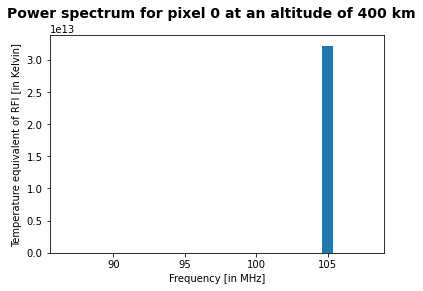

In [37]:
##Power spectrum for pixel 1 at an altitude of 400 km

plt.bar(freq,power_output[0,0,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for pixel 0 at an altitude of 400 km',fontsize=14, fontweight="bold")

In [36]:
##Received power by the satellite at an altitude 400 km when overhead pixel position(or number) 2 at all frequencies##

power_output[0,2,:]

array([0, 0, 0, 0, 0, 0, 10452354859040.04, 4464681790228.062, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2749603819717.3022, 0,
       7184629427245.644, 0, 0, 42416671320016.08, 834907985591.3741, 0,
       0, 8968955581623.75, 0, 0, 0, 0, 0, 31271757314670.773, 0, 0, 0,
       590484635078.221, 0], dtype=object)

Text(0.5, 0.98, 'Power spectrum for pixel 2 at an altitude of 400 km')

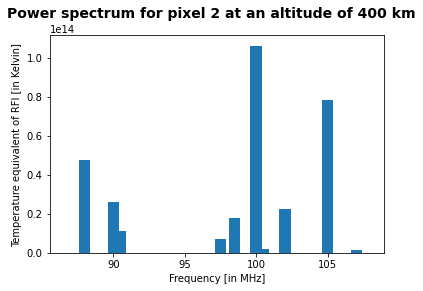

In [38]:
##Power spectrum for pixel 2 at an altitude of 400 km

plt.bar(freq,power_output[0,2,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for pixel 2 at an altitude of 400 km',fontsize=14, fontweight="bold")

In [38]:
##Received power by the satellite at an altitude 3794 km when overhead pixel position(or number) 0 at all frequencies##

power_output[1,0,:]

array([0, 413368940932702.44, 3740858652228731.0, 6267493711938763.0,
       3310320285451945.0, 4578994935651991.0, 3200004967885939.5,
       4032369131867258.0, 3360916683864593.0, 3616967755910359.5,
       3233953024119492.5, 3465613558498054.5, 2397160280463756.5,
       2640361823639671.5, 2260375177133407.5, 4100979943630457.0,
       2552036311896121.0, 3455440453228389.0, 2350818887525230.5,
       3678910744694117.0, 1891668322161757.0, 3160668933288696.0,
       2430432309587723.0, 3225393948257697.5, 2433733645718487.5,
       2365686257849127.0, 2447720241066821.0, 3189426952488858.5,
       2248424865874422.0, 2467894491043808.0, 1960876113334884.8,
       2892924536551601.0, 1935705543076308.8, 2792215025675844.0,
       2516459960908361.5, 2432290432074550.5, 2288061274615090.5,
       3229618311961656.5, 2179827623094633.2, 2428987588708040.0,
       1786423937807859.5, 3704295506137765.0], dtype=object)

Text(0.5, 0.98, 'Power spectrum for pixel 0 at an altitude of 3794 km')

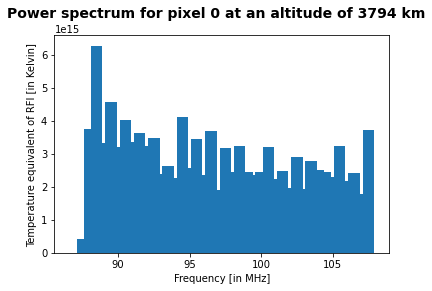

In [39]:
##Power spectrum for pixel 0 at an altitude of 3794 km

plt.bar(freq,power_output[1,0,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for pixel 0 at an altitude of 3794 km',fontsize=14, fontweight="bold")

In [336]:
##Received power by the satellite at an altitude 36000 km when overhead pixel position(or number) 0 at all frequencies##

np.shape(power_output[2,:,:])

(192, 42)

Text(0.5, 0.98, 'Power spectrum for pixel 0 at an altitude of 36000 km')

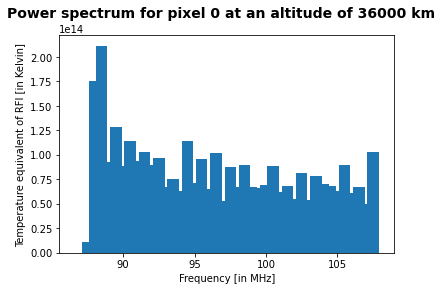

In [338]:
##Power spectrum for pixel 0 at an altitude of 36000 km #####

plt.bar(freq,power_output[2,0,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for pixel 0 at an altitude of 36000 km',fontsize=14, fontweight="bold")

In [42]:
power_output[0,:,6]

array([0, 0, 10452354859040.04, ..., 0, 0, 0], dtype=object)

In [38]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 400 km at 90 MHz----------------------#######

test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[0,:,6])] = power_output[0,:,6]


0.0 180.0 -180.0 180.0


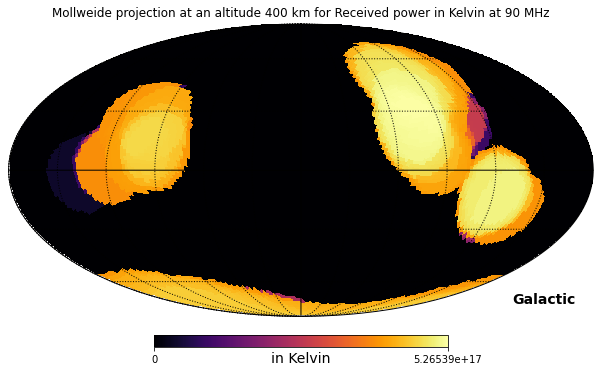

In [40]:
hp.mollview(test_plot,coord=['C','G'],cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


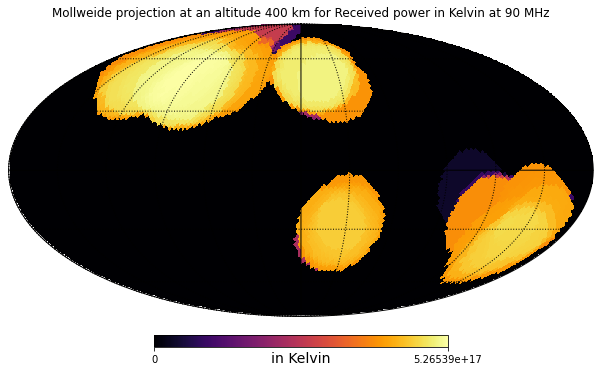

In [44]:
hp.mollview(test_plot,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [114]:
test_plot0001 = np.zeros(hp.nside2npix(nside))
test_plot0001[0:np.size(power_output[0,:,6])] = power_output[0,:,6]
hp.mollview(test_plot0001,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()


0.0 180.0 -180.0 180.0


In [118]:
!which python

/home/ghoshsonia/anaconda3/bin/python


In [117]:
len(altitude)

2

In [116]:
freq[36]

105.0

0.0 180.0 -180.0 180.0


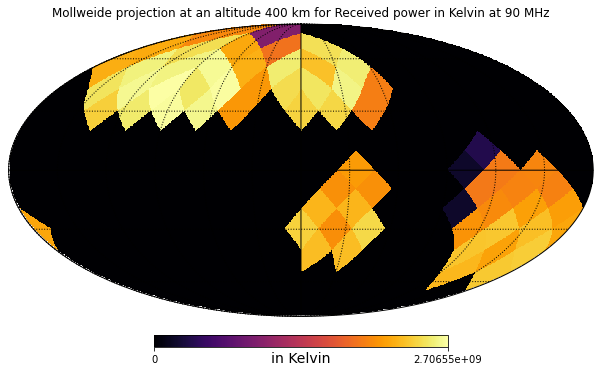

In [120]:
test_plot0001 = np.zeros(hp.nside2npix(nside))
test_plot0001[0:np.size(power_output[0,:,6])] = power_output[0,:,6]
hp.mollview(test_plot0001,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


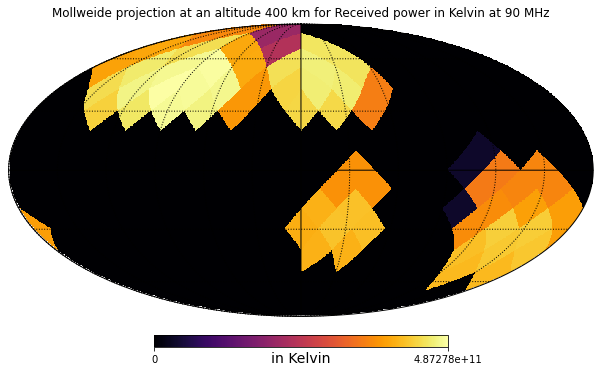

In [446]:
test_plot0001 = np.zeros(hp.nside2npix(nside))
test_plot0001[0:np.size(DIFF[0,:,6])] = DIFF[0,:,6]
hp.mollview(test_plot0001,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


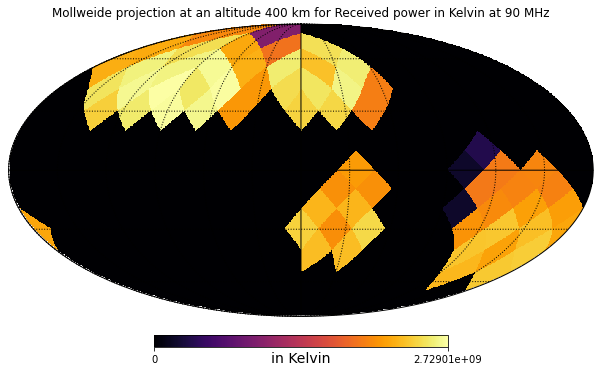

In [437]:
test_plot001 = np.zeros(hp.nside2npix(nside))
test_plot001[0:np.size(power_output1[0,:,6])] = power_output1[0,:,6]
hp.mollview(test_plot001,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


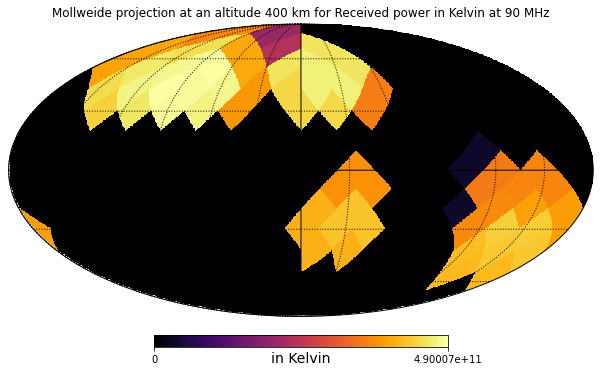

In [444]:
test_plot00 = np.zeros(hp.nside2npix(nside))
test_plot00[0:np.size(power_output[0,:,6])] = power_output[0,:,6]
hp.mollview(test_plot00,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [408]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 400 km at 90 MHz----------------------#######

test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[2,:,6])] = power_output[2,:,6]


0.0 180.0 -180.0 180.0


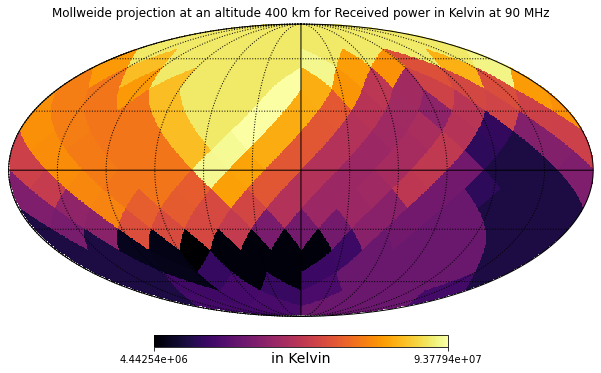

In [409]:
hp.mollview(test_plot,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


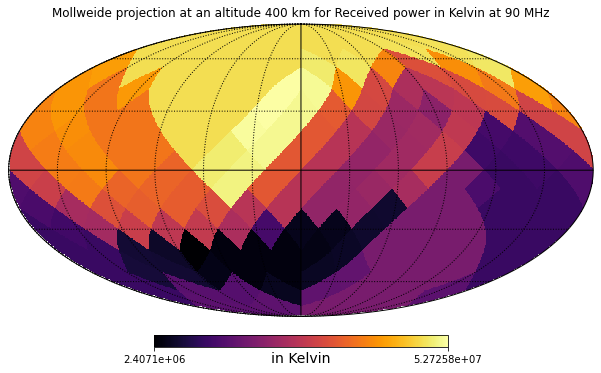

In [414]:
test_plot00 = np.zeros(hp.nside2npix(nside))
test_plot00[0:np.size(power_output[2,:,40])] = power_output[2,:,40]
hp.mollview(test_plot00,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()


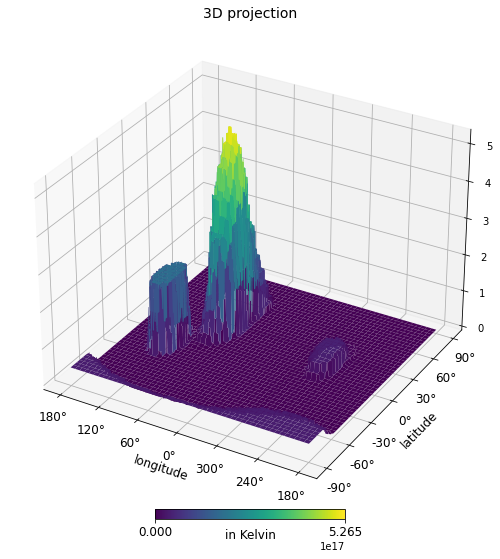

In [41]:
projview(
    test_plot,
    coord=["C","G"],
    hold=False,
    graticule=True,
    graticule_labels=True,
    unit="in Kelvin",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    projection_type="3d",
    title="3D projection",
    );

In [41]:
# Replacing the power value of 0 to a minimum value 1.000001 in order to apply logarithmic equalization in 
# the Healpy map


power_output_log=np.where(power_output[0,:,6]==0, 1.0000001, power_output[0,:,6])
power_output_log

array([1.0000001, 1.0000001, 26130887147600.1, ..., 1.0000001, 1.0000001,
       1.0000001], dtype=object)

array([ 0.        ,  0.        , 29.97784841, ...,  0.        ,
        0.        ,  0.        ])

In [42]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 400 km at 90 MHz with logarithmic equalization----------------------#######


test_plot12 = np.zeros(hp.nside2npix(nside))
test_plot12[0:np.size(power_output[0,:,6])] = power_output_log
test_plot12=np.where(test_plot12==0, 1.0000001,test_plot12 )

0.0 180.0 -180.0 180.0


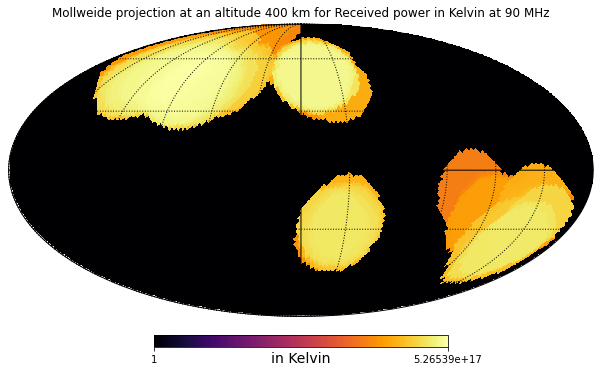

In [43]:
hp.mollview(test_plot12,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm="log")#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


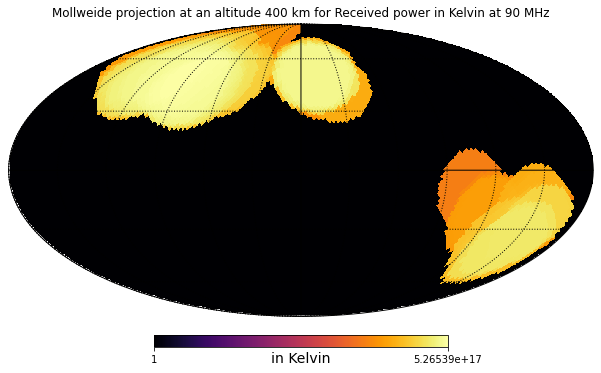

In [69]:
hp.mollview(test_plot12,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm="log")#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [52]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 400 km at 100 MHz----------------------#######


test_plot1 = np.zeros(hp.nside2npix(nside))
test_plot1[0:np.size(power_output[0,:,26])] = power_output[0,:,26]


0.0 180.0 -180.0 180.0


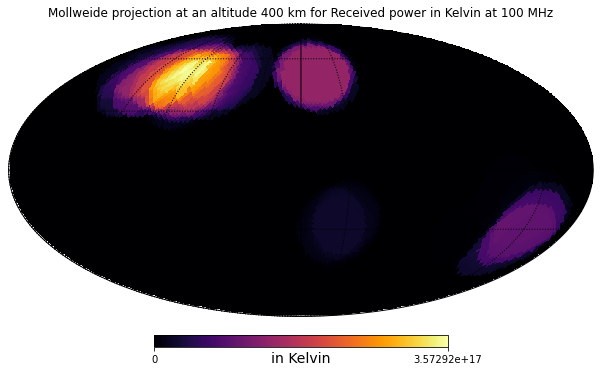

In [55]:
hp.mollview(test_plot1,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 100 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


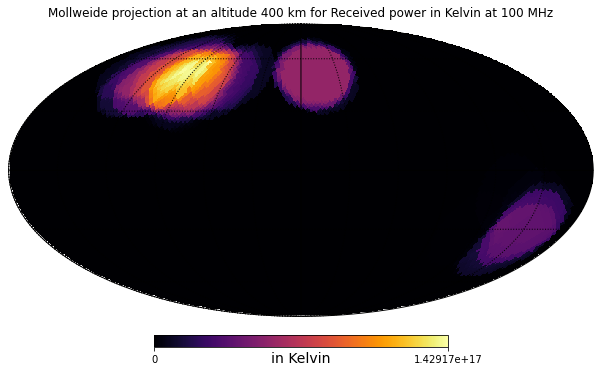

In [55]:
hp.mollview(test_plot1,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 100 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [42]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 3794 km at 90 MHz----------------------#######


test_plot4 = np.zeros(hp.nside2npix(nside))
test_plot4[0:np.size(power_output[1,:,6])] = power_output[1,:,6]

0.0 180.0 -180.0 180.0


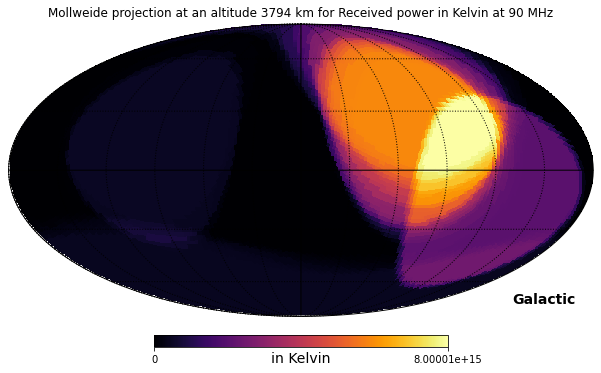

In [44]:
hp.mollview(test_plot4,coord=['C','G'],cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 90 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


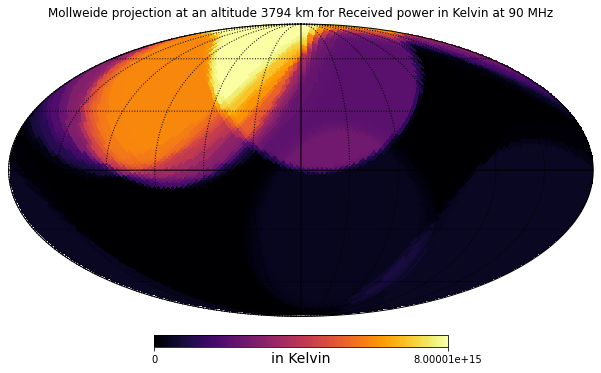

In [57]:
hp.mollview(test_plot4,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 90 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


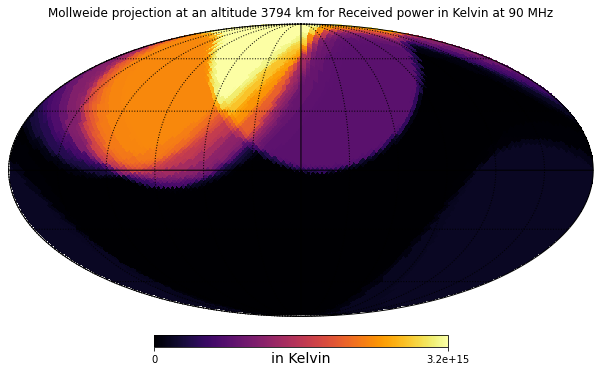

In [57]:
hp.mollview(test_plot4,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 90 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [58]:
# Replacing the power value of 0 to a minimum value 1.000001 in order to apply logarithmic equalization in 
# the Healpy map


power_output_log1=np.where(power_output[1,:,6]==0, 1.0000001, power_output[1,:,6])
np.shape(power_output_log1)

(12288,)

In [59]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 3794 km at 90 MHz with logarithmic equalization----------------------#######


test_plot13 = np.zeros(hp.nside2npix(nside))
test_plot13[0:np.size(power_output[1,:,6])] = power_output_log1
test_plot13=np.where(test_plot13==0, 1.0000001,test_plot13 )

0.0 180.0 -180.0 180.0


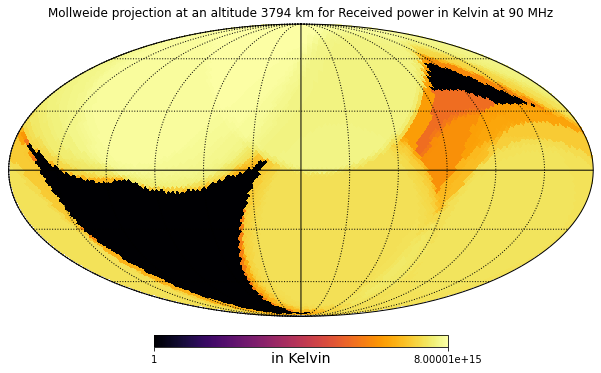

In [60]:
hp.mollview(test_plot13,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 90 MHz",flip='geo',norm="log")#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


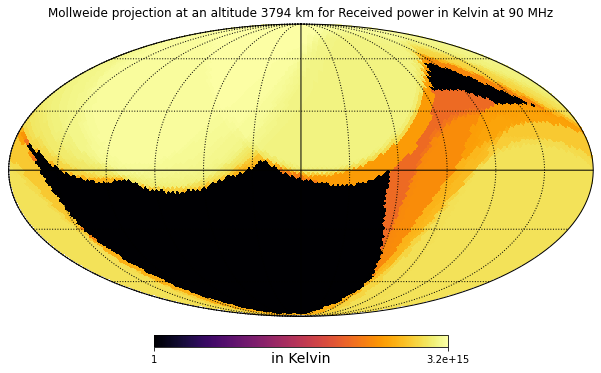

In [60]:
hp.mollview(test_plot13,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 90 MHz",flip='geo',norm="log")#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [61]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 3794 km at 100 MHz----------------------#######


test_plot2 = np.zeros(hp.nside2npix(nside))
test_plot2[0:np.size(power_output[1,:,26])] = power_output[1,:,26]


0.0 180.0 -180.0 180.0


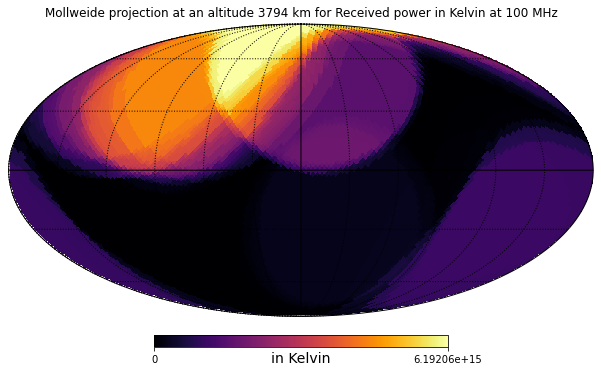

In [62]:
hp.mollview(test_plot2,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 100 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


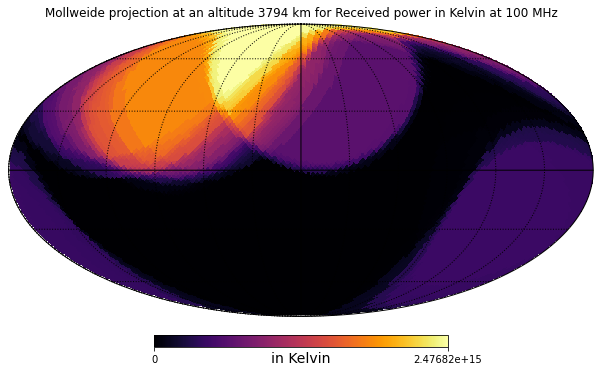

In [62]:
hp.mollview(test_plot2,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 3794 km for Received power in Kelvin at 100 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [63]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 36000 km at 90 MHz----------------------#######


test_plot5 = np.zeros(hp.nside2npix(nside))
test_plot5[0:np.size(power_output[2,:,6])] = power_output[2,:,6]

0.0 180.0 -180.0 180.0


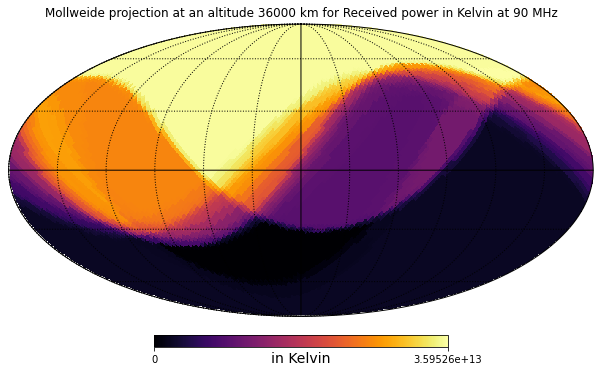

In [64]:
hp.mollview(test_plot5,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 36000 km for Received power in Kelvin at 90 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [65]:
# Replacing the power value of 0 to a minimum value 1.000001 in order to apply logarithmic equalization in 
# the Healpy map


power_output_log2=np.where(power_output[2,:,6]==0, 1.0000001, power_output[2,:,6])
np.shape(power_output_log2)

(12288,)

In [66]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 36000 km at 90 MHz with logarithmic equalization----------------------#######


test_plot14 = np.zeros(hp.nside2npix(nside))
test_plot14[0:np.size(power_output[2,:,6])] = power_output_log2
test_plot14=np.where(test_plot14==0, 1.0000001,test_plot14 )

0.0 180.0 -180.0 180.0


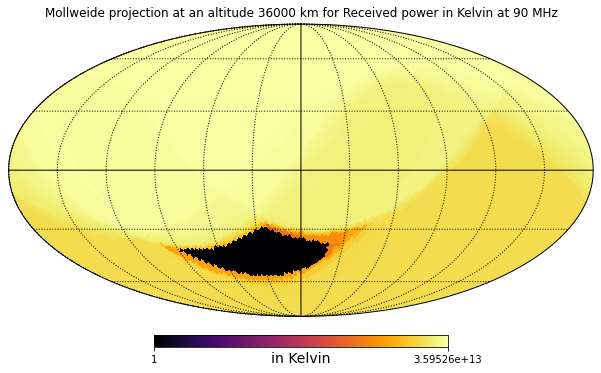

In [67]:
hp.mollview(test_plot14,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 36000 km for Received power in Kelvin at 90 MHz",flip='geo',norm="log")#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [63]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 36000 km at 100 MHz----------------------#######


test_plot3 = np.zeros(hp.nside2npix(nside))
test_plot3[0:np.size(power_output[2,:,26])] = power_output[2,:,26]


0.0 180.0 -180.0 180.0


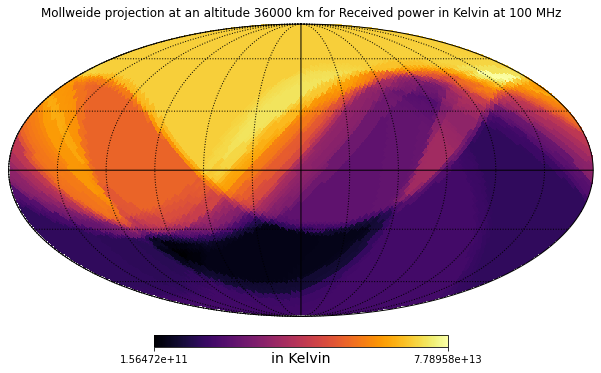

In [64]:
hp.mollview(test_plot3,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 36000 km for Received power in Kelvin at 100 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

0.0 180.0 -180.0 180.0


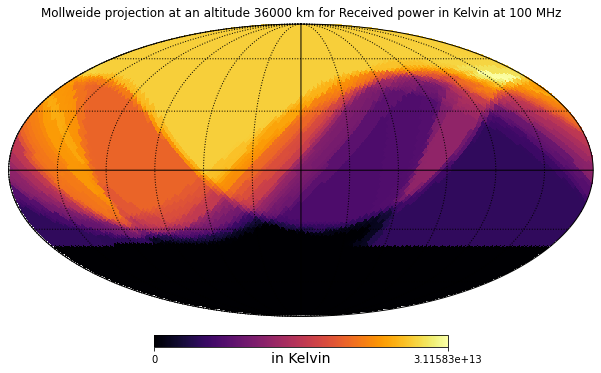

In [62]:
hp.mollview(test_plot3,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 36000 km for Received power in Kelvin at 100 MHz",flip='geo')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()